In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import json

In [3]:
#using pyspark as our dataframe for big data
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, col
import pyspark.sql.functions as F

## Get IMDB data from Google Cloud public-datasets
This dataset contains data about all the movies in IMDB. We use Google Big Query to pull the data in form of csv 

In [4]:
# from google.cloud import bigquery
# from google.oauth2 import service_account
# import json

# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# secret_value = user_secrets.get_secret("key")

# credentials = service_account.Credentials.from_service_account_info(
#     json.loads(secret_value)
# )
# client = bigquery.Client(credentials=credentials)

In [5]:
# # from google.cloud import bigquery

# query = '''
#         SELECT title_type,primary_title,genres,runtime_minutes,
#         num_votes,average_rating 
#         FROM `bigquery-public-data.imdb.title_ratings` AS rating 
#         JOIN `bigquery-public-data.imdb.title_basics` AS title
#         ON rating.tconst=title.tconst 
#         LIMIT 1000
#         '''
# # # Run the query and save the results to a DataFrame
# datafirst = client.query(query)

# ds = [(row.title_type,row.primary_title,row.genres,row.runtime_minutes,row.num_votes,row.average_rating)
#       for row in datafirst]
# # print(ds)
# df = pd.DataFrame(ds,columns=['title_type','primary_title','genres','runtime_minutes',
#                               'num_votes','average_rating'])
# df.head()
# df.to_csv('imdb_data.csv', index = False, encoding='utf-8')

In [6]:
# Creating a SparkSession object
spark = SparkSession.builder.appName('imdb_viz').getOrCreate()

# Importing a CSV file as a DataFrame
df = spark.read.csv('/Users/rupakpantha/Documents/DS_project/imdb_data1.csv', header=True, inferSchema=True)


23/03/23 08:27:48 WARN Utils: Your hostname, Rupaks-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.64 instead (on interface en0)
23/03/23 08:27:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/23 08:27:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
df.show(10)

+----------+--------------------+-------------------+---------------+---------+--------------+----------+
|title_type|       primary_title|             genres|runtime_minutes|num_votes|average_rating|start_year|
+----------+--------------------+-------------------+---------------+---------+--------------+----------+
|     movie|       Hidden Agenda|              Drama|           65.0|        8|           9.6|      null|
| tvEpisode|There are Some Pe...|        Crime,Drama|           null|       18|           7.5|      null|
|  tvSeries|The Wonderful Wor...|        Documentary|           60.0|       16|           7.1|      null|
|     movie|You Don't Know Ni...|        Documentary|           null|       39|           8.5|      null|
|     movie|The Great 14th: T...|        Documentary|           82.0|      152|           9.3|      null|
|     movie|Luccas Neto em: A...|      Comedy,Family|           87.0|       76|           2.5|      null|
|     movie|       Prem Prakaran|      Drama,R

In [8]:
summary = df.describe()
summary.show()

+-------+----------+----------------+-------+------------------+----------------+------------------+------------------+
|summary|title_type|   primary_title| genres|   runtime_minutes|       num_votes|    average_rating|        start_year|
+-------+----------+----------------+-------+------------------+----------------+------------------+------------------+
|  count|      1000|            1000|    957|               676|            1000|              1000|               986|
|   mean|      null|            null|   null|36.421597633136095|         352.905| 5.472900000000001| 1913.052738336714|
| stddev|      null|            null|   null|45.499024729874286|4134.09463128209|1.2109425964809275|10.445082762488315|
|    min|     movie|  $1, 000 Reward| Action|               1.0|               5|               1.0|            1883.0|
|    max|  tvSeries|Études sur Paris|Western|             410.0|          112956|               9.7|            1929.0|
+-------+----------+----------------+---

In [9]:
df.printSchema()

root
 |-- title_type: string (nullable = true)
 |-- primary_title: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- runtime_minutes: double (nullable = true)
 |-- num_votes: integer (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- start_year: double (nullable = true)



In [ ]:
from pyspark.sql.types import DateType

# Use the to_date() function to convert the date column from double to date format
df = df.withColumn("start_year", F.to_date(F.col("start_year"), "yyyy").cast(DateType()))

# Show the updated DataFrame
df.show()

# Vizualizations

## Relationship between Votes and Ratings
We can explore the relationship between the number of votes and movie ratings. We can plot a scatter plot to see if there is a correlation between the two variables.

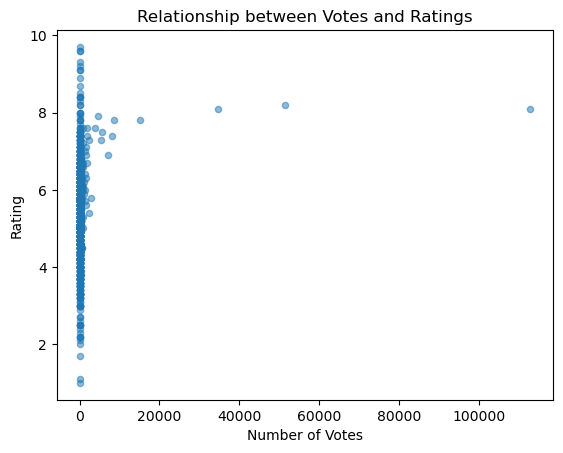

In [10]:
# Select necessary columns
vote_rating_df = df.select("num_votes", "average_rating")

# Plot the scatter plot of votes and ratings
vote_rating_df.toPandas().plot(kind='scatter', x='num_votes', y='average_rating', alpha=0.5)
plt.xlabel("Number of Votes")
plt.ylabel("Rating")
plt.title("Relationship between Votes and Ratings")
plt.show()

## Runtime by Year
We can explore how the runtime of movies has changed over the years. We can plot a line chart to see the trend in movie runtime.

In [ ]:
import pyspark.sql.functions as F

# Select necessary columns
runtime_year_df = df.select("start_year", "runtime_minutes")

# Group by year and calculate the average runtime
avg_runtime_df = runtime_year_df.groupBy("start_year").agg(F.avg("runtime_minutes").alias("avg_runtime"))

# Plot the trend of average runtime over the years
avg_runtime_df.toPandas().plot(kind='line', x='start_year', y='avg_runtime')
plt.xlabel("Year")
plt.ylabel("Average Runtime (minutes)")
plt.title("Average Runtime of Movies over the Years")
plt.show()

## Bar Chart of Title Type

In [ ]:
from pyspark.sql.functions import count

title_type_counts = df.groupBy('title_type').agg(count('*').alias('count')).orderBy('count')
title_type_counts_pd = title_type_counts.toPandas()

plt.bar(title_type_counts_pd['title_type'], title_type_counts_pd['count'])
plt.title('Title Type Frequencies')
plt.xlabel('Title Type')
plt.ylabel('Frequency')
plt.show()

## Scatter Plot

In [ ]:
# Create a scatter plot of runtime vs. average rating
plt.scatter(df.select("runtime_minutes").rdd.flatMap(lambda x: x).collect(),
            df.select("average_rating").rdd.flatMap(lambda x: x).collect())
plt.xlabel("Runtime (minutes)")
plt.ylabel("Average Rating")
plt.show()

## Heatmap of correlation matrix: 
Use a heatmap to visualize the correlation matrix between the numerical variables in the dataset

In [ ]:
# Select the numerical columns and convert to a Pandas DataFrame
num_df = df.select("runtime_minutes", "num_votes", "average_rating").toPandas()

# Calculate the correlation matrix and plot a heatmap
corr_matrix = num_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

## Stacked Bar Chart of Genres by Title Type

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.functions import explode, split, count, desc


# Group by title type and genre, count the number of records, and order by title type and count
genres_by_title_type = df.select('title_type', explode(split('genres', ',')).alias('genre')) \
                        .groupBy('title_type', 'genre') \
                        .agg(count('*').alias('count')) \
                        .orderBy('title_type', desc('count'))

# Window function to rank genres by count within each title type
from pyspark.sql.window import Window
window = Window.partitionBy('title_type').orderBy(desc('count'))
genres_by_title_type = genres_by_title_type.withColumn('rank', F.row_number().over(window))

# Select only the top 5 genres for each title type
genres_by_title_type = genres_by_title_type.filter(genres_by_title_type.rank <= 5)

# Convert the resulting DataFrame to a Pandas DataFrame
genres_by_title_type_pd = genres_by_title_type.toPandas()

# Pivot the data and plot a stacked bar chart
genres_by_title_type_pd.pivot(index='title_type', columns='genre', values='count').plot(kind='bar', stacked=True)

plt.title('Top 5 Genres by Title Type')
plt.xlabel('Title Type')
plt.ylabel('Count')
plt.show()


In [ ]:
from pyspark.sql.functions import explode, split, count

genres_by_title_type = df.select('title_type', explode(split('genres', ',')).alias('genre')) \
                        .groupBy('title_type', 'genre') \
                        .agg(count('*').alias('count')) \
                        .orderBy('title_type', 'count')

genres_by_title_type_pd = genres_by_title_type.toPandas()

genres_by_title_type_pd.pivot(index='title_type', columns='genre', values='count').plot(kind='bar', stacked=True)

plt.title('Genres by Title Type')
plt.xlabel('Title Type')
plt.ylabel('Count')
plt.show()


In [ ]:
runtime_minutes = df.select("runtime_minutes").toPandas()
plt.hist(runtime_minutes, bins=20)
plt.title("Distribution of Runtime Minutes")
plt.xlabel("Runtime Minutes")
plt.ylabel("Count")
plt.show()

## Distribution of rating

In [ ]:
import pyspark.sql.functions as F

# Select necessary columns
rating_df = df.select("average_rating")

# Plot the distribution of ratings
rating_df.toPandas().plot(kind='hist', bins=10, alpha=0.5)
plt.xlabel("Rating")
plt.title("Distribution of Movie Ratings")
plt.show()
